## Baseline model for bus 203

This notebook creates a baseline model for bus 203, and calculates the prediction error on the test set.

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dateutil.parser
import pickle
import math
%matplotlib inline
sns.set()

In [38]:
train = pickle.load(open('benchmark_train.pkl', 'rb'))
test = pickle.load(open('benchmark_test.pkl', 'rb'))

In [3]:
#bus_line_file = '../bus203_all.csv'

In [39]:
# convert timestamp columns to pandas datetimes
train['timestamp'] = pd.to_datetime(train['timestamp'])
train['timestamp'] = train['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

test['timestamp'] = pd.to_datetime(test['timestamp'])
test['timestamp'] = test['timestamp'].dt.tz_localize('UTC').dt.tz_convert('Europe/Stockholm')

In [4]:
# sanity check
print('train data rows comprise {:.4f}% of the total data'
      .format(len(train.index) / (len(train.index) + len(test.index))))
print('test data rows comprise {:.4f}% of the total data'
      .format(len(test.index) / (len(train.index) + len(test.index))))

train data rows comprise 0.8000% of the total data
test data rows comprise 0.2000% of the total data


### Calculate the median travel times for each segment in the train data

In [40]:
train.head(1)

,Unnamed: 0,timestamp,event,vehicle_id,line,longitude,latitude,direction,speed,station,journey_number,segment_number
0,0,2018-02-16 04:48:40+01:00,JourneyStartedEvent,5432,203,58.414238,15.571015,-1.0,-1.0,NaN,1,1


Now lets calculate the median travel time in the segments of the train data, which will be used to make predictions.

In [41]:
def get_travel_time(x):
    """
    Get the travel time within the current segment
    """
    timedelta = x.max() - x.min()
    return timedelta.seconds

In [42]:
# get segment time for each segment in each journey
train['segment_time'] = train.groupby(['journey_number', 'segment_number'])['timestamp'].transform(get_travel_time)

In [43]:
test['segment_time'] = test.groupby(['journey_number', 'segment_number'])['timestamp'].transform(get_travel_time)

Now we want to get the average time it took to drive each segment. Since we have the segment time duplicated over all rows with the same journey number and segment number, we need to only take this number once to not get a skewed weighting of the average. We can group by journey_number and segment_number, and take any aggregate function (min, max, mean) since the segment time is the same for each row where the journey number and segment number are the same.

In [44]:
a = train.groupby(['journey_number', 'segment_number']).min().reset_index()

In [45]:
medians = dict(a.groupby('segment_number')['segment_time'].median())

These are our median travel times for each segment:

In [46]:
medians

{1: 188,
 2: 56,
 3: 63,
 4: 43,
 5: 52,
 6: 61,
 7: 99,
 8: 46,
 9: 157,
 10: 73,
 11: 69}

In [47]:
pickle.dump(medians, open('medians_203.p', 'wb'))

### Get the errors of the predictions on segment duration vs the actual segment durations in the test set

Now we can go through the test data and make predictions using the median travel times for each segment. Comments in code below describes the procedure.

In [48]:
 def get_prediction_error(start_time, segment_name, segment_data):
    # min() becomes the min timestamp of this slice, 
    # while start_time is the min timestamp on the whole segment 
    timedelta = segment_data['timestamp'].min() - start_time
    # get how much time the bus has already spent in this slice of the segment
    time_passed = timedelta.seconds
    # subtract that from the total time the segment takes    
    time_left = segment_data['segment_time'].iloc[0] - time_passed
    # subtract the spend time from our prediction as well
    time_pred = medians[segment_name] - time_passed
    # get the error in seconds from our prediction vs the true travel time
    error_s = time_left - time_pred
    # get error as a percentage of the true travel time left
    error_p = error_s / time_left * 100
    # get absolute values of the errors
    abs_error_s = abs(error_s)
    abs_error_p = abs(error_p)
    return error_s, error_p, abs_error_s, abs_error_p

In [49]:
i = 0
data = []
for name, group in test.groupby(['journey_number', 'segment_number']):
    seg_len = len(group.index)
    intervals = [(math.floor(seg_len * i/10), f'{i}0_p') for i in range(0, 10, 2)]
    start_time = group['timestamp'].min()
    # calculate our errors for each slice of the segment
    for (idx, interval) in intervals: 
        error_s, error_p, abs_error_s, abs_error_p = get_prediction_error(start_time, name[1], group[idx:])
        data.append([name[1], interval, error_s, error_p, abs_error_s, abs_error_p])

In [50]:
error_df = pd.DataFrame(columns=['segment', 'slice', 'error_s', 'error_p', 'abs_error_s', 'abs_error_p'], data=data)

In [52]:
error_df.head(5)

,segment,slice,error_s,error_p,abs_error_s,abs_error_p
0,1,00_p,23,10.900474,23,10.900474
1,1,20_p,23,13.609467,23,13.609467
2,1,40_p,23,18.253968,23,18.253968
3,1,60_p,23,27.710843,23,27.710843
4,1,80_p,23,54.761905,23,54.761905


# ERROR RESULTS HERE

Dataframe above holds our prediction errors on the test set. To can now get our MAPE for the segments and the segment slices, by looking at the means of the `abs_error_p` column. The values of the column "slice", such as `20_p`, `40_p`, means predictions after travelling 20%, 40% etc.

In [53]:
print('MAPE: {:.2f}%'.format(error_df[error_df.slice != '00_p']['abs_error_p'].mean()))
print('MAE: {:.2f}s'.format(error_df[error_df.slice != '00_p']['abs_error_s'].mean()))

MAPE: 61.37%
MAE: 14.96s


In [60]:
# Including 0-100% slice (slice == 00_p included)
print('MAPE: {:.2f}%'.format(error_df['abs_error_p'].mean()))
print('MAE: {:.2f}s'.format(error_df['abs_error_s'].mean()))

MAPE: 53.79%
MAE: 14.96s


In [54]:
error_df.groupby('slice').mean()

,segment,error_s,error_p,abs_error_s,abs_error_p
slice,,,,,
00_p,6.0,0.982449,-8.769628,14.956187,23.499963
20_p,6.0,0.982449,-9.965228,14.956187,28.190532
40_p,6.0,0.982449,-13.521419,14.956187,37.701776
60_p,6.0,0.982449,-21.273479,14.956187,57.387250
80_p,6.0,0.982449,-48.135473,14.956187,122.192006


In [55]:
error_df.groupby('segment').mean()

,error_s,error_p,abs_error_s,abs_error_p
segment,,,,
1,6.227778,-6.001516,27.500000,35.888835
2,0.231944,-20.169048,11.006944,53.328318
3,-0.845833,-18.579576,10.893056,46.523203
4,-4.193056,-65.705515,12.840278,100.167665
5,4.241667,6.887666,9.950000,36.280987
6,-2.038889,-22.689279,11.797222,50.599299
7,4.645833,2.062543,14.856944,30.933370
8,-4.348611,-61.893772,13.159722,93.344960
9,5.637500,1.883475,20.123611,26.514226


In [59]:
# without 0%-100% slice/complete segment (slice == 00_p)
error_df[error_df.slice != '00_p'].groupby('segment').mean()

,error_s,error_p,abs_error_s,abs_error_p
segment,,,,
1,6.227778,-6.820090,27.500000,40.926821
2,0.231944,-23.016971,11.006944,60.819380
3,-0.845833,-21.200794,10.893056,53.047417
4,-4.193056,-75.124221,12.840278,114.411643
5,4.241667,7.825013,9.950000,41.355413
6,-2.038889,-25.889043,11.797222,57.689026
7,4.645833,2.354630,14.856944,35.276419
8,-4.348611,-70.703109,13.159722,106.552086
9,5.637500,2.149277,20.123611,30.225684


In [56]:
error_df.groupby(['segment', 'slice']).mean()

error_s     error_p  abs_error_s  abs_error_p
segment slice                                                
1       00_p   6.227778   -2.727222    27.500000    15.736892
        20_p   6.227778   -3.330580    27.500000    19.510551
        40_p   6.227778   -4.337248    27.500000    26.031874
        60_p   6.227778   -6.354286    27.500000    39.201317
        80_p   6.227778  -13.258244    27.500000    78.963541
2       00_p   0.231944   -8.777357    11.006944    23.364072
        20_p   0.231944   -9.878520    11.006944    27.936197
        40_p   0.231944  -13.249998    11.006944    37.454441
        60_p   0.231944  -21.146940    11.006944    56.804317
        80_p   0.231944  -47.792426    11.006944   121.082564
3       00_p  -0.845833   -8.094703    10.893056    20.426344
        20_p  -0.845833   -9.375703    10.893056    24.646969
        40_p  -0.845833  -12.598850    10.893056    32.840408
        60_p  -0.845833  -19.781849    10.893056    49.846409
        80_p  -0.845833  -43.046774    10.893056   104.855882
4       00_p  -4.193056  -28.030691    12.840278    43.191753
        20_p  -4.193056  -31.549813    12.840278    50.286864
        40_p  -4.193056  -42.956499    12.840278    68.031240
        60_p  -4.193056  -67.920301    12.840278   104.638600
        80_p  -4.193056 -158.070272    12.840278   234.689869
5       00_p   4.241667    3.138276     9.950000    15.983286
        20_p   4.241667    4.106603     9.950000    19.445183
        40_p   4.241667    5.071683     9.950000    25.704493
        60_p   4.241667    7.511122     9.950000    39.021339
        80_p   4.241667   14.610645     9.950000    81.250636
6       00_p  -2.038889   -9.890223    11.797222    22.240391
        20_p  -2.038889  -11.475576    11.797222    26.754039
        40_p  -2.038889  -15.647937    11.797222    35.697693
        60_p  -2.038889  -24.160610    11.797222    54.217950
        80_p  -2.038889  -52.272049    11.797222   114.086423
7       00_p   4.645833    0.894196    14.856944    13.561170
        20_p   4.645833    1.173127    14.856944    16.812604
        40_p   4.645833    1.763452    14.856944    22.264243
        60_p   4.645833    2.352363    14.856944    33.394368
        80_p   4.645833    4.129579    14.856944    68.634462
8       00_p  -4.348611  -26.656428    13.159722    40.516458
        20_p  -4.348611  -30.502880    13.159722    47.630148
        40_p  -4.348611  -41.385950    13.159722    64.141019
        60_p  -4.348611  -64.905915    13.159722    98.609519
        80_p  -4.348611 -146.017689    13.159722   215.827659
9       00_p   5.637500    0.820270    20.123611    11.668394
        20_p   5.637500    1.067767    20.123611    14.364504
        40_p   5.637500    1.381516    20.123611    19.137410
        60_p   5.637500    2.051537    20.123611    28.817345
        80_p   5.637500    4.096286    20.123611    58.583478
10      00_p   0.912500   -6.916337    15.448611    23.142918
        20_p   0.912500   -8.028787    15.448611    28.153071
        40_p   0.912500  -10.715513    15.448611    37.351210
        60_p   0.912500  -16.765010    15.448611    56.695172
        80_p   0.912500  -36.765070    15.448611   118.466473
11      00_p   0.336111  -10.225691    16.941667    28.667912
        20_p   0.336111  -11.823149    16.941667    34.555729
        40_p   0.336111  -16.060268    16.941667    46.065505
        60_p   0.336111  -24.888379    16.941667    70.013416
        80_p   0.336111  -55.104188    16.941667   147.671077

In [57]:
error_df.groupby(['slice', 'segment']).mean()

error_s     error_p  abs_error_s  abs_error_p
slice segment                                                
00_p  1        6.227778   -2.727222    27.500000    15.736892
      2        0.231944   -8.777357    11.006944    23.364072
      3       -0.845833   -8.094703    10.893056    20.426344
      4       -4.193056  -28.030691    12.840278    43.191753
      5        4.241667    3.138276     9.950000    15.983286
      6       -2.038889   -9.890223    11.797222    22.240391
      7        4.645833    0.894196    14.856944    13.561170
      8       -4.348611  -26.656428    13.159722    40.516458
      9        5.637500    0.820270    20.123611    11.668394
      10       0.912500   -6.916337    15.448611    23.142918
      11       0.336111  -10.225691    16.941667    28.667912
20_p  1        6.227778   -3.330580    27.500000    19.510551
      2        0.231944   -9.878520    11.006944    27.936197
      3       -0.845833   -9.375703    10.893056    24.646969
      4       -4.193056  -31.549813    12.840278    50.286864
      5        4.241667    4.106603     9.950000    19.445183
      6       -2.038889  -11.475576    11.797222    26.754039
      7        4.645833    1.173127    14.856944    16.812604
      8       -4.348611  -30.502880    13.159722    47.630148
      9        5.637500    1.067767    20.123611    14.364504
      10       0.912500   -8.028787    15.448611    28.153071
      11       0.336111  -11.823149    16.941667    34.555729
40_p  1        6.227778   -4.337248    27.500000    26.031874
      2        0.231944  -13.249998    11.006944    37.454441
      3       -0.845833  -12.598850    10.893056    32.840408
      4       -4.193056  -42.956499    12.840278    68.031240
      5        4.241667    5.071683     9.950000    25.704493
      6       -2.038889  -15.647937    11.797222    35.697693
      7        4.645833    1.763452    14.856944    22.264243
      8       -4.348611  -41.385950    13.159722    64.141019
      9        5.637500    1.381516    20.123611    19.137410
      10       0.912500  -10.715513    15.448611    37.351210
      11       0.336111  -16.060268    16.941667    46.065505
60_p  1        6.227778   -6.354286    27.500000    39.201317
      2        0.231944  -21.146940    11.006944    56.804317
      3       -0.845833  -19.781849    10.893056    49.846409
      4       -4.193056  -67.920301    12.840278   104.638600
      5        4.241667    7.511122     9.950000    39.021339
      6       -2.038889  -24.160610    11.797222    54.217950
      7        4.645833    2.352363    14.856944    33.394368
      8       -4.348611  -64.905915    13.159722    98.609519
      9        5.637500    2.051537    20.123611    28.817345
      10       0.912500  -16.765010    15.448611    56.695172
      11       0.336111  -24.888379    16.941667    70.013416
80_p  1        6.227778  -13.258244    27.500000    78.963541
      2        0.231944  -47.792426    11.006944   121.082564
      3       -0.845833  -43.046774    10.893056   104.855882
      4       -4.193056 -158.070272    12.840278   234.689869
      5        4.241667   14.610645     9.950000    81.250636
      6       -2.038889  -52.272049    11.797222   114.086423
      7        4.645833    4.129579    14.856944    68.634462
      8       -4.348611 -146.017689    13.159722   215.827659
      9        5.637500    4.096286    20.123611    58.583478
      10       0.912500  -36.765070    15.448611   118.466473
      11       0.336111  -55.104188    16.941667   147.671077

## Plotting histograms of our errors

#### Percentage errors

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


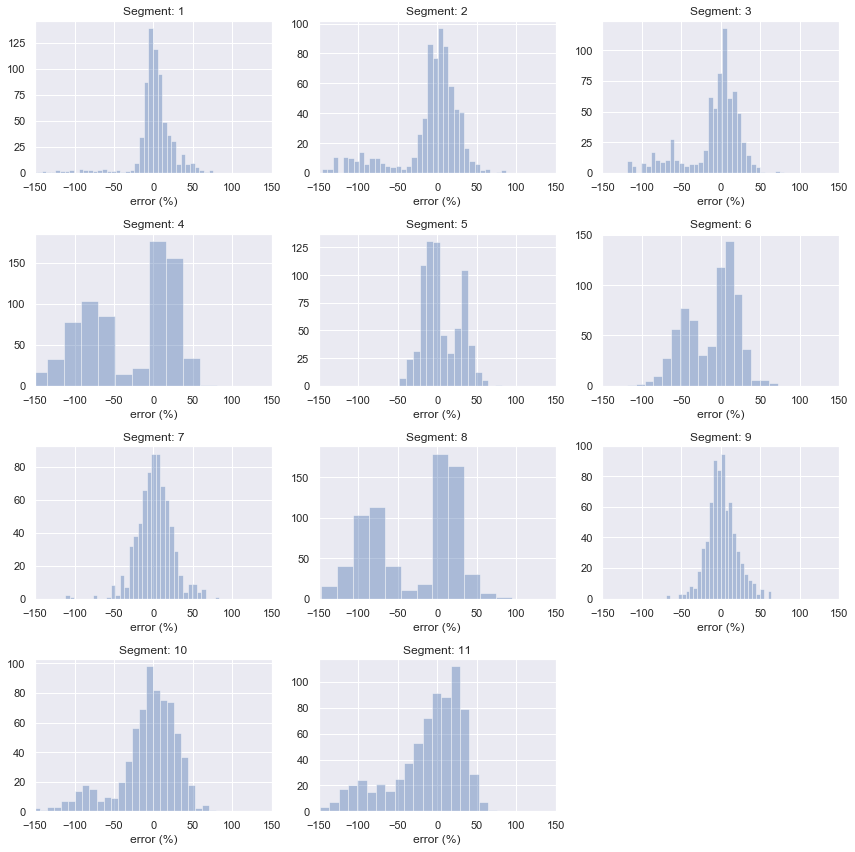

In [35]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_p, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()

#### Errors in seconds

/home/max/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/max/anaconda3/lib/python3.6/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/max/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


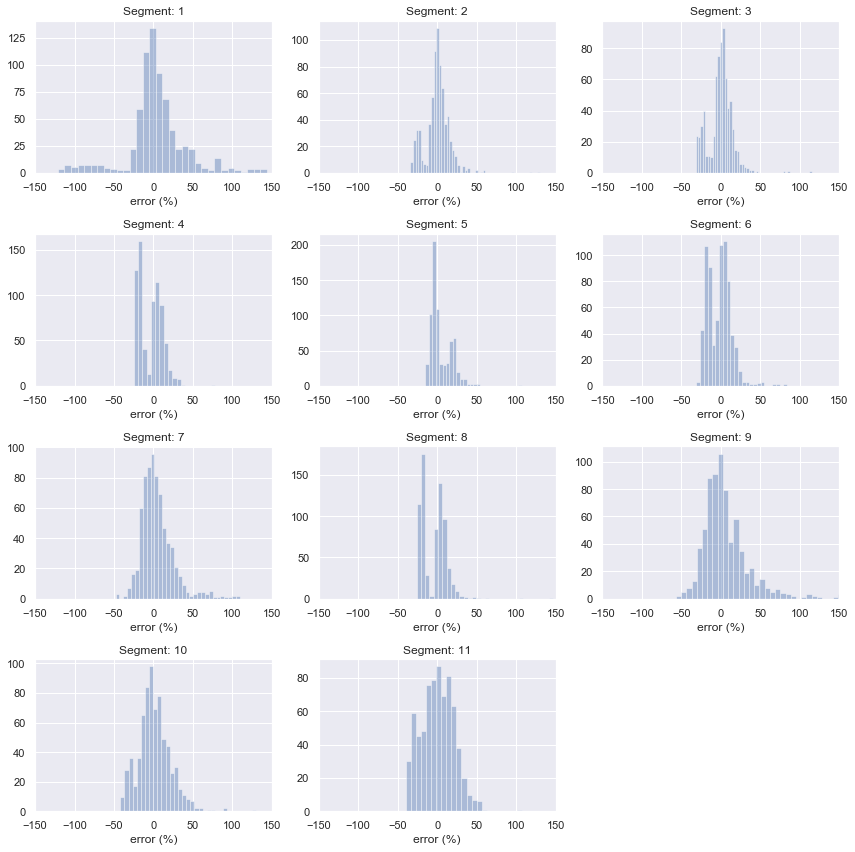

In [36]:
fig, axes = plt.subplots(4, 3, figsize=(12,12))
for i, ax in enumerate(axes.flatten()):
    _=sns.distplot(error_df[(error_df.segment == i+1) & (error_df.slice == '20_p')].error_s, kde=False, ax=ax)
    ax.set_title(f'Segment: {i+1}')
    ax.set_xlabel('error (%)')
    ax.set_xlim(-150, 150)
fig.delaxes(ax)
plt.tight_layout()
plt.show()